In [1]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [2]:
import os
import subprocess
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

In [4]:
directory = 'gs://msca-bdp-students-bucket/shared_data/linhcle/final_project/clean2/'
# file = '*.json'
# path = directory + file
path = directory

In [5]:
cmd = 'hadoop fs -du -s -h ' + directory

p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
for line in p.stdout.readlines():
    print (line)
    
retval = p.wait()

6.1 G  6.1 G  gs://msca-bdp-students-bucket/shared_data/linhcle/final_project/clean2



In [6]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True) 

In [7]:
%%time

tweets_df_clean = spark.read.parquet(path)

CPU times: user 4.39 ms, sys: 4.82 ms, total: 9.21 ms
Wall time: 8.23 s


### IV. Location Analysis

In [9]:
user_type = tweets_df_clean.select(col('user_screen_name').alias('retweeted_status_user_screen_name'),col('user_type').alias('retweeted_status_user_type')).drop_duplicates()

In [10]:
tweets_df_complete = tweets_df_clean.join(user_type,tweets_df_clean['retweeted_status_user_screen_name'] == user_type['retweeted_status_user_screen_name'],how='left').drop(user_type['retweeted_status_user_screen_name'])

In [11]:
tweets_df_complete = tweets_df_complete.dropDuplicates(['user_screen_name','id','text','created_at'])

In [12]:
tweets_location = tweets_df_complete[~tweets_df_complete.tweet_longitude.isNull()]

In [ ]:
tweets_location_pd = tweets_location[['user_screen_name','id','text','created_at','retweeted_status_retweet_count','retweeted_status_user_screen_name','tweet_longitude','tweet_latitude']].toPandas()

22/12/08 04:25:32 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 4 for reason Container marked as failed: container_1670472833918_0001_01_000004 on host: hub-msca-bdp-dphub-students-backup-linhcle-sw-grhw.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/08 04:25:32 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 6 for reason Container marked as failed: container_1670472833918_0001_01_000006 on host: hub-msca-bdp-dphub-students-backup-linhcle-sw-grhw.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/08 04:25:32 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 4 on hub-msca-bdp-dphub-students-backup-linhcle-sw-grhw.c.msca-bdp-students.internal: Container marked as failed: container_1670472833918_0001_01_000004 on 

#### Topics in education: "math book ban", "school shooting", "standardized tests", "student loan", "teacher tenure"

In [ ]:
tweets_topics = tweets_location.filter(lower(col('text')).contains('math book ban')|\
                                   lower(col('text')).contains('school shooting')|\
                                   lower(col('text')).contains('standardized test')|\
                                   lower(col('text')).contains('student loan')|\
                                   lower(col('text')).contains('teacher tenure'))

In [20]:
tweets_location_pd = tweets_location_pd[tweets_location_pd.text.str.contains('math book ban | school shooting | standardized test | student loan | teacher tenure',case=False, regex=True)]

In [16]:
type(tweets_location_pd)

pandas.core.frame.DataFrame

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


<AxesSubplot:>

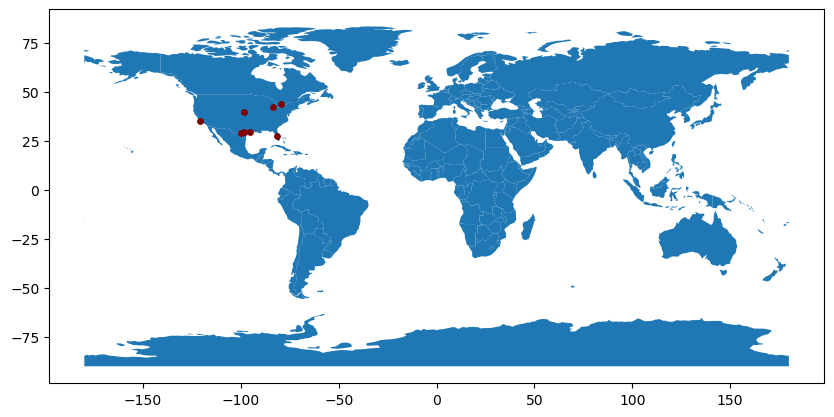

In [21]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


geometry = [Point(xy) for xy in zip(tweets_location_pd['tweet_longitude'], tweets_location_pd['tweet_latitude'])]
gdf = GeoDataFrame(tweets_location_pd, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='maroon', markersize=15,)